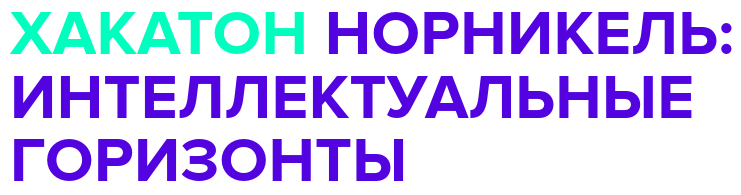

# Мультимодальные RAG модели 🔍️📊

## Контекст проекта

* **Организация:** ПАО "Норильский никель" 🏢
* **Направление:** Искусственный интеллект и анализ данных 💻📊
* **Формат:** Хакатон по разработке инновационных решений 🏆

## Проблематика 🤔
В современных производственных компаниях, особенно в металлургической и горнодобывающей отраслях, существует острая необходимость в эффективной обработке больших объемов разнородной информации, быстром извлечении релевантных знаний из документов, мультимодальном анализе данных (текст, изображения, графики) и поддержке принятия решений на основе глубокого понимания контекста. Традиционные методы работы с документами часто оказываются неэффективными.

## Цель проекта 🎯
Основная цель проекта - разработка мультимодальной системы интеллектуального поиска и анализа информации, использующей современные методы машинного обучения и обработки естественного языка.

# 1. Установка и импорт нужных инструментов

Установим требуемые нам библиотеки: 
* `byaldi` - высокоуровневый [фреймворк](https://github.com/AnswerDotAI/byaldi) непосредственно для работы с моделями ColPali
* `pdf2image` - для перевода `.pdf`-файлов в изображения
* `poppler-utils` - для работы `pdf2image`
* `Spire.Doc` - для перевода `.docx`-файлов в формат `.pdf`
* `qwen-vl-utils` - для работы Qwen-VL-моделей

Так же для работы обязательно потребуются данные (сами документы), предоставленные организаторами хакатона (архив `RAG.zip` весом в 450,4 МБ).

Так как вся работа велась на Kaggle с использованием `GPU T4 x2`, то документы при загрузке до их обработке лежали в папке `/kaggle/input/nornikel-2024`.

In [1]:
!pip install --upgrade byaldi -q
!sudo apt-get install -y poppler-utils -q
!pip install -q pdf2image flash-attn -q
!pip install Spire.Doc -q
!pip install qwen-vl-utils -q

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libpoppler118 poppler-data
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  libpoppler118 poppler-data poppler-utils
0 upgraded, 3 newly installed, 0 to remove and 72 not upgraded.
Need to get 3427 kB of archives.
After this operation, 17.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 poppler-data all 0.4.11-1 [2171 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler118 amd64 22.02.0-2ubuntu0.5 [1071 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 3427 kB in 1s (4649 kB/s)
Selecting previously unselected package poppler-data.

Определим папку, где у нас лежат первоначальные данные `input_folder`, а так же папку, куда мы переведём файлы непосредственно для работы с RAG-системой `working_folder`.

In [2]:
from byaldi import RAGMultiModalModel
import torch
from pdf2image import convert_from_path
import os
import shutil
from spire.doc import *
from spire.doc.common import *
import gzip
import json
from PIL import Image, ImageFilter


#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
input_folder = '/kaggle/input/nornikel-2024/'
working_folder = '/kaggle/working/nornikel-2024/'

if not os.path.exists(working_folder):
    os.makedirs(working_folder)

# 2. Подготовка данных

In [3]:
def convert_doc_to_pdf(doc_path, pdf_path):
    '''Конвертация файлов MS Word в .pdf'''
    document = Document()
    document.LoadFromFile(doc_path)
    document.SaveToFile(pdf_path, FileFormat.PDF)
    document.Close()

In [4]:
all_documents = os.listdir(input_folder)

for file in all_documents:
    file_path = os.path.join(input_folder, file)
    if file_path.endswith('.docx') or file_path.endswith('.doc'):
        file_path = convert_doc_to_pdf(file_path, working_folder + file[:-4] + 'pdf')
        print(f"Копирован и переведён в формат .pdf файл: {file[:-4] + 'pdf'}")
    else:
        shutil.copy(file_path, working_folder)
        print(f"Копирован файл: {file}")

Копирован файл: Alrosa_Обзор_рынка_инвестиционных_бриллиантов_октябрь_2024.pdf
Копирован файл: Росконгресс_Рынок_промышленных_роботов_в_мире_и_России_2024_16_стр.pdf
Копирован файл: nn_climate_change_report_rus.pdf
Копирован файл: Норникель про корп культуру.pdf
Копирован файл: ММК 2024.pdf
Копирован файл: Доклад, уголь часть 1.pdf
Копирован файл: Godovoi_-otchet-PAO-GMK-Norilskii_-nikel-za-2023-god.pdf
Копирован файл: sr_ru_annual_report_pages_nornik_2022.pdf
Копирован файл: Норникель_Внутрення_цена_на_углерод.pdf
Копирован файл: 2_5282802846297776741.pdf
Копирован и переведён в формат .pdf файл: СП_496_1325800_2020_Основания_и_фундаменты_зданий_и_сооружений.pdf
Копирован файл: digital_production_5.pdf
Копирован файл: NN_AR_2021_Book_RUS_26.09.22.pdf
Копирован файл: McKinsey_Next Big Arenas_2024 (213 pgs).pdf
Копирован файл: KPMG_Global Metals and Mining_2024 (48 pgs).pdf
Копирован файл: NN_CSO2021_RUS_03.03.2023.pdf
Копирован файл: 2022_Annual_Report_of_PJSC_MMC_Norilsk_Nickel_rus.

Определим метод RAGMultiModalModel из библиотеки byaldi, который отвечает за создание мультимодальной RAG-системы с помощью модели ColPali. На данный момент стабильная версия считается `vidore/colpali-v1.2`.

# 3. Создание векторной базы данных

In [5]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2", device=device)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Создадим нашу векторную базу из всех документов, которые у нас есть. Необходимо, чтобы данные лежали в папке `working_folder`.

In [ ]:
RAG.index(
    input_path=working_folder,
    index_name='nornikel_index',
    store_collection_with_index=False,
    overwrite=True
)

Indexing file: /kaggle/working/nornikel-2024/Росконгресс_Рынок_промышленных_роботов_в_мире_и_России_2024_16_стр.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Index exported to .byaldi/nornikel_index
Indexing file: /kaggle/working/nornikel-2024/nn_climate_change_report_rus.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Added page 5 of do

Сформируем текстовый запрос, чтобы убедиться, что модель работает. Определим k страниц, где есть релевантная информация.

In [ ]:
text_query = "Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?"
results = RAG.search(text_query, k=5)

In [ ]:
for result in results:
    doc_id = result['doc_id']
    page_num = result['page_num']
    score = result['score']

    print(f"Документ ID: {doc_id}, Страница: {page_num}, Релевантность: {score}")

Сохраним нашу векторную базу для дальнейшей эксплуатации.

In [ ]:
from zipfile import ZipFile

byaldi_folder = '/kaggle/working/.byaldi' # папка, в которой лежит векторная БД
archive_name = '/kaggle/working/byaldi.zip' # создаваемый нами архив с векторной БД
if os.path.exists(byaldi_folder):
    shutil.make_archive(archive_name.replace('.zip', ''), 'zip', byaldi_folder)
    print(f"Архив создан: {archive_name}")
else:
    print(f"Папка {byaldi_folder} не найдена.")

# 4. Работа с Qwen-2-VL

Так как ColPali не считывает напрямую текст с документов и изображений, нам потребуется языковая LLM или VLM. Для ответа по релевантным страницам документов и текстовому запросу используем VLM-модель `Qwen-2-VL-2B`, а именно дообученную на русских текстах версию от Vikhrmodels: `Vikhr-2-VL-2b-Instruct-experimental`.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

model_id = "Vikhrmodels/Vikhr-2-VL-2b-Instruct-experimental"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id, torch_dtype="auto", device_map="cuda:1"
)

processor = AutoProcessor.from_pretrained(model_id)

Ниже мы берём релевантные страницы разных документов и переводим их в изображения. С целью оптимизации потребрения оперативной памяти снизим размер изображения примерно до 1000 пикселей в длине.

In [ ]:
def resize_text(img, max_size=1000):
    '''Изменение размера изображения'''
    width, height = img.size
    if max(width, height) > max_size:
        if width > height:
            new_width = max_size
            new_height = int(height * (max_size / width))
        else:
            new_height = max_size
            new_width = int(width * (max_size / height))
            
        img = img.resize((new_width, new_height), Image.LANCZOS)
        img = img.filter(ImageFilter.SHARPEN)

    return img

In [ ]:
def get_relevant_images_ready(docs_names, results):
    '''Функция-пайплайн для подготовки релевантных страниц к текстовому запросу'''
    images = [docs_names[results[i]['doc_id']] for i in range(len(results))]
    image_path = '/kaggle/working/nornikel-2024/relevant_images/'
    
    os.makedirs(image_path, exist_ok=True)
    pages_to_convert = dict()
    
    for doc, page in zip(images, [doc['page_num'] for doc in results]):
        pages_to_convert.setdefault(doc, []).append(page)
    
    ready_images_for_context = []
    
    for i, (pdf, pages) in enumerate(pages_to_convert.items()):
        for j, page in enumerate(pages):
            output_img_name = f'{image_path}/image_{i + 1}_{j + 1}.jpg'
            
            image = convert_from_path(pdf, first_page=page, last_page=page)
            image = resize_text(*image)
            image.save(output_img_name, 'JPEG')

            ready_images_for_context.append(output_img_name)
    

    return ready_images_for_context

In [ ]:
relevant_images = get_relevant_images_ready(docs_names, results)

# 5. Выполнение поискового запроса в VLM

Формируем контент для контектного окна, куда мы передаём наш текстовый запрос и пути по готовых изображений.

In [ ]:
content = [
    *[{"type": "image", "image": image} for image in relevant_images],
    {"type": "text", "text": text_query}
]

role_text = '''Ты бизнес-ассистент в компании Норникель. По существу и профессионально ответь на вопрос, опираясь на контекст изображений.'''

In [ ]:
messages = [
    {"role": "system", "content": [{"type": "text", "text": role_text}]},
    {
        "role": "user",
        "content": content,
    }
]

display(messages)

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda:1")

После передачи текстового запроса в модель получаем готовый сгенерированный моделью ответ.

In [ ]:
generated_ids = model.generate(
    **inputs,
    max_length=2048,
    temperature=0.3,
    top_k=100,
    top_p=0.95,
    max_new_tokens=1024
)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

torch.cuda.empty_cache()

print(output_text[0])

# 6. Тест ответов на тренировочные вопросы хакатона

Выпишем себе вопросы, которые задавались бы нашей системе в рамках тренировки.

In [ ]:
questions = '''1. Долевое участие металлов в EBITDA компании? То есть какой % EBITDA и EBITDA margin принесли продажи Ni, Cu и т д
2. Как эта доля менялась от года к году (наверн нужно приложить отчеты хотя бы за 2-3 года)?
3. Топ 5 факторов снижения EBITDA г/г? Также и EBITDA margin
4. Какой актив формирует наибольшую долю FCF? Какой актив на 2 месте?
5. Какие активы являются убыточными? Можно ли их исключить из производственной цепочки без последствий для общего цикла производства металлов?
6. Какой прогноз по содержанию металлов руд НН на следующие 5 лет? 
7. Какую долю рынка занимает НН в производстве металлов? Как изменялась доля НН г/г? Какой прогноз на 5 лет?
8. Как изменялся прогноз по предложению и спросу на Ni, Cu, Au в отчетах за разные года, например какой был прогноз в отчете за 2020 год на 2021/22/23? Какое было фактическое предложение и спрос в годовых отчетах 2021/22/23? Исходя из этого сделай вывод о целесообразности доверия таким прогнозам в целом'''

In [ ]:
questions = [q[3:] for q in questions.split('\n')]
display(questions)

Далее составим функцию-пайплайн, которая будет содержать главные моменты: через получение запроса поиск релевантных страниц в документах, перевод этих страниц в изображения с уменьшением размерности, а так же составлением промпта с передачей его в VLM для генерации ответа на вопрос пользователя в текстовом запросе.

In [ ]:
def get_answer_on_query(text_query, k=3, model=model, processor=processor, role_text=role_text):
    '''Функция-пайплан для поиска по вектрной базе, обработки релевантных страниц документов и генерация ответа'''
    
    # 1. Поиск релевантных страниц в векторной базе
    results = RAG.search(text_query, k=k)

    # 2. Перевод релевантных страниц в изображения
    relevant_images = get_relevant_images_ready(docs_names, results)

    # 3. Формирование промпта
    content = [
    *[{"type": "image", "image": image} for image in relevant_images],
    {"type": "text", "text": text_query}
    ]

    messages = [
    {"role": "system", "content": [{"type": "text", "text": role_text}]},
    {
        "role": "user",
        "content": content,
    }
    ]

    # 4. Токенизация промпта

    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda:1")

    # 5. Передача затокенизированного промпта в VLM
    generated_ids = model.generate(
    **inputs,
    max_length=2048,
    temperature=0.3,
    top_k=100,
    top_p=0.95,
    max_new_tokens=1024
    )
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    # 6. Вывод на экран вопроса пользователя, сгенерированного ответа и релевантные изображения
    print('-' * 50)
    print('user_question:', text_query)
    print()
    print('VLM_answer:', output_text[0])

    img1 = Image.open(relevant_images[0])
    img2 = Image.open(relevant_images[1])
    combined_image = Image.concat(images=[img1, img2], direction="horizontal")
    combined_image.show()
    
    print('-' * 50)
    
    shutil.rmtree("/kaggle/working/nornikel-2024/relevant_images")
    os.makedirs("/kaggle/working/nornikel-2024/relevant_images")

    torch.cuda.empty_cache()

Запустим ниже процесс генерации ответов

In [ ]:
role_text = '''Ты бизнес-ассистент в компании Норникель. По существу и профессионально ответь на вопрос, опираясь на контекст изображений.'''

for i, q in enumerate(questions, start=1):
    print(f'Question {i}')
    get_answer_on_query(q)

# Заключение 🏁

Данный ноутбук содержит всю необходимую информацию для реализации мультимодальной системы интеллектуального поиска и анализа данных в рамках хакатона Норникеля. 

Ключевые компоненты решения включают:
- Препроцессинг и векторизацию разнородных данных 
- Построение семантического поиска с использованием технологий RAG и ColPali
- Применение мультимодальной языковой модели Qwen-2-VL для генерации контекстных ответов

Реализация этих компонентов позволит разработать эффективную систему, способную обрабатывать большие объемы информации из различных источников, обеспечивая быструю и точную индексацию, а также повышая общую продуктивность работы с документами в производственной среде. 🚀